In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# 기상청 데이터 - 서울의 기온과 습도

## Data preprocessing

In [3]:
seoul_h = pd.read_csv('/content/drive/MyDrive/기상청/humidity_seoul.csv',encoding='cp949')
seoul_t = pd.read_csv('/content/drive/MyDrive/기상청/temperature_seoul.csv',encoding='cp949')

In [4]:
seoul_h = seoul_h.dropna()
seoul_h

,\t\t지점번호,지점명,일시,평균습도(%rh),최저습도(%rh)
0,\t\t108,서울,2022-01-12,49.0,12.0
1,\t\t108,서울,2022-02-12,43.0,11.0
2,\t\t108,서울,2022-03-12,52.0,9.0
3,\t\t108,서울,2022-04-12,54.0,9.0
4,\t\t108,서울,2022-05-12,48.0,11.0
...,...,...,...,...,...
118,\t\t108,서울,2022-11-21,68.0,27.0
119,\t\t108,서울,2022-12-21,62.0,26.0
120,\t\t108,서울,2022-01-22,55.0,21.0
121,\t\t108,서울,2022-02-22,55.0,21.0


In [5]:
seoul_t = seoul_t.dropna()
seoul_t

,\t\t지점번호,지점명,일시,평균기온(℃),평균최고기온(℃),최고기온(℃),\t최고기온일자,평균최저기온(℃),최저기온(℃),최저기온일자
0,\t\t108,서울,2022-01-12,-2.8,1.3,8.4,2012-01-19,-6.3,-12.2,2012-01-23
1,\t\t108,서울,2022-02-12,-2.0,3.0,12.1,2012-02-22,-6.0,-17.1,2012-02-02
2,\t\t108,서울,2022-03-12,5.1,9.5,16.2,2012-03-29,1.5,-5.7,2012-03-12
3,\t\t108,서울,2022-04-12,12.3,17.9,29.4,2012-04-30,7.8,0.6,2012-04-07
4,\t\t108,서울,2022-05-12,19.7,25.1,29.3,2012-05-22,15.4,12.0,2012-05-18
...,...,...,...,...,...,...,...,...,...,...
118,\t\t108,서울,2022-11-21,8.2,13.1,21.3,2021-11-07,4.0,-3.7,2021-11-23
119,\t\t108,서울,2022-12-21,0.6,5.1,13.3,2021-12-08,-3.5,-15.5,2021-12-26
120,\t\t108,서울,2022-01-22,-2.2,2.6,8.4,2022-01-24,-6.2,-11.3,2022-01-12
121,\t\t108,서울,2022-02-22,-1.1,3.8,11.5,2022-02-28,-5.3,-10.7,2022-02-17


In [6]:
# date = seoul_t[['일시']]
date = pd.date_range('2012-01','2022-04',freq='M')
date = pd.DataFrame(date)
date = date.astype('str')
date

,0
0,2012-01-31
1,2012-02-29
2,2012-03-31
3,2012-04-30
4,2012-05-31
...,...
118,2021-11-30
119,2021-12-31
120,2022-01-31
121,2022-02-28


In [7]:
for i in range(len(date)):
    k = list(date.loc[i][:6])
    k = k[0][:7]
    date.loc[i] = k
date

,0
0,2012-01
1,2012-02
2,2012-03
3,2012-04
4,2012-05
...,...
118,2021-11
119,2021-12
120,2022-01
121,2022-02


In [8]:
avg_t = seoul_t[['평균기온(℃)']]
avg_h = seoul_h[['평균습도(%rh)']]

final = pd.concat([date,avg_t,avg_h],axis=1)
final.columns = ['월','평균기온(℃)','평균습도(%rh)']
final

,월,평균기온(℃),평균습도(%rh)
0,2012-01,-2.8,49.0
1,2012-02,-2.0,43.0
2,2012-03,5.1,52.0
3,2012-04,12.3,54.0
4,2012-05,19.7,48.0
...,...,...,...
118,2021-11,8.2,68.0
119,2021-12,0.6,62.0
120,2022-01,-2.2,55.0
121,2022-02,-1.1,55.0


## 독립 변수(습도), 종속 변수(기온) 설정

In [9]:
ind_var = final[['평균습도(%rh)']] 
dep_var = final[['평균기온(℃)']]

### Loss 값을 줄이기 위해 데이터 정규화 과정 거침

In [10]:
minmax = MinMaxScaler()

ind_var = np.asarray(ind_var).astype(np.float32)
dep_var = np.asarray(dep_var).astype(np.float32)

scaled_ind = minmax.fit_transform(ind_var)
scaled_dep = minmax.fit_transform(dep_var)

## 모델 구축 및 모델 학습

In [11]:
X = tf.keras.layers.Input(shape=[1])
H = tf.keras.layers.Dense(10, activation = 'swish')(X)
Y = tf.keras.layers.Dense(1)(X)
model_seoul = tf.keras.models.Model(X,Y)
model_seoul.compile(loss='mse')

model_seoul.fit(scaled_ind, scaled_dep, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 2s 4ms/step - loss: 0.0600
Epoch 2/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0594
Epoch 3/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0591
Epoch 4/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0588
Epoch 5/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0586
Epoch 6/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0584
Epoch 7/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0583
Epoch 8/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0582
Epoch 9/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0580
Epoch 10/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0579
Epoch 11/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0579
Epoch 12/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.0579
Epoch 13/1000
4/4 [==============================

## 값 비교

In [12]:
pred = model_seoul.predict(scaled_ind)
pred_ = minmax.inverse_transform(pred)
pred_[0:5]

array([[ 4.0395737 ],
       [-0.82574826],
       [ 6.4722323 ],
       [ 8.094005  ],
       [ 3.228686  ]], dtype=float32)

In [13]:
dep_var[0:5]

array([[-2.8],
       [-2. ],
       [ 5.1],
       [12.3],
       [19.7]], dtype=float32)

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


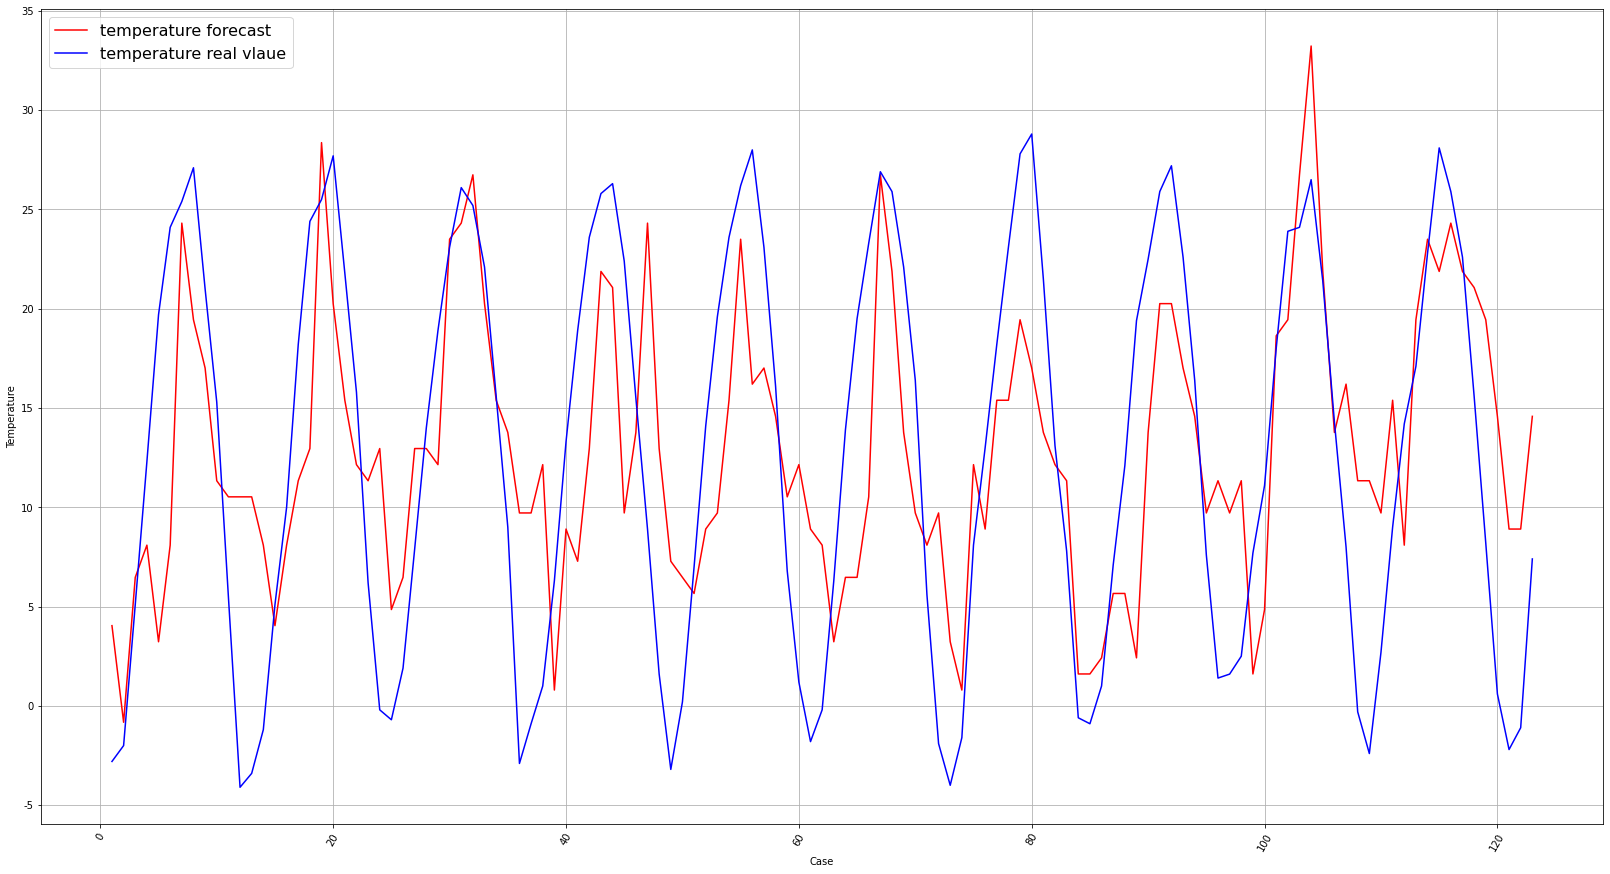

In [14]:
plt.rc('font', family='NanumGothic')
matplotlib.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(28,15))
fig.set_facecolor('white')


date__ = final[['평균습도(%rh)']] 
date_line = []

for i in range(len(final)):
  k = date__.loc[i]
  date_line.append(k[0])

case = []

for i in range(1,124):
  case.append(i)

plt.plot(case,pred_,color='r',label='temperature forecast')
plt.plot(case,dep_var, color = 'b',label='temperature real vlaue')
# plt.plot(date_line,ind_var,color='r',label='습도 실제값')
plt.legend()
plt.xlabel('Case')
plt.ylabel('Temperature')
plt.xticks(rotation = '60')
plt.grid()
plt.legend(fontsize=16,loc='upper left')
plt.show()